# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [1]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.optimize import minimize

%matplotlib inline

/home/miriam/.local/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


# Einlesen mit h5py

In [2]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [3]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None


## Daten einlesen mit pyfact

In [4]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

# Limits für theata^2 - Plot

In [5]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [6]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [7]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [8]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


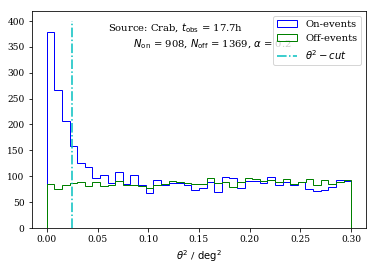

In [9]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))
plt.savefig('On_Off.pdf')
print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

In [10]:
max_bin = max(max(gammas_sel['gamma_energy_prediction']), max(gammas_sel['corsika_event_header_total_energy']))
min_bin = min(min(gammas_sel['gamma_energy_prediction']), min(gammas_sel['corsika_event_header_total_energy']))
print(min_bin)
if max_bin <= max(np.logspace(np.log10(500),np.log10(50e3),11)):
    print('Durch obere binning Grenze werden keine events aussortiert, da höchster vorkommender Wert: {}!'.format(max_bin))
    b = 12
    bins1 = np.ones(b)
else:
    b = 13
    bins1 = np.ones(b)
    bins1[-1] = max_bin
bins1[0] = 0

for i in range(1, b, 1):
    bins1[i] = np.logspace(np.log10(500),np.log10(50e3),11)[i-1]
print(bins1)

205.58768
Durch obere binning Grenze werden keine events aussortiert, da höchster vorkommender Wert: 49990.832!
[    0.           500.           792.44659623  1255.94321575
  1990.53585277  3154.7867224   5000.          7924.46596231
 12559.43215755 19905.35852767 31547.86722401 50000.        ]


In [11]:
bins2 = np.ones(7)
bins2[0] = 0
for i in range(1, 7, 1):
    bins2[i] = np.logspace(np.log10(500),np.log10(50e3),6)[i-1]
print(bins2)

[    0.           500.          1255.94321575  3154.7867224
  7924.46596231 19905.35852767 50000.        ]


Matrix hat neue shape:  (11, 6)


<Figure size 432x288 with 0 Axes>

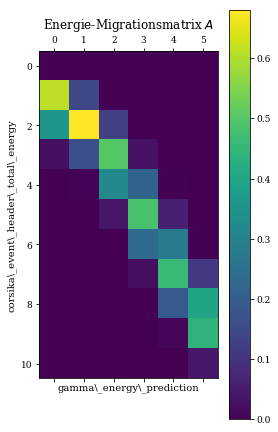

In [12]:
plt.figure(constrained_layout=True)
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             bins1,
                                             bins2,
                                         ])
matrix = matrix/np.sum(matrix,axis=0) #hier erfolgt die Normierung
plt.matshow(matrix)
plt.xlabel('gamma\_energy\_prediction')
plt.ylabel('corsika\_event\_header\_total\_energy')
plt.title('Energie-Migrationsmatrix $A$')
plt.colorbar()
plt.savefig('Matrix.pdf')
print('Matrix hat neue shape: ', np.shape(matrix))

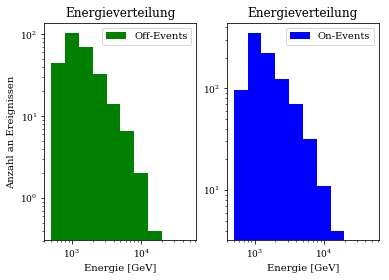

In [13]:
# Untergrund binnen
plt.subplot(1,2,1)
a = np.full_like(bkg['gamma_energy_prediction'], 0.2)
b, bins_b, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge, weights=a, color='g', label='Off-Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.ylabel('Anzahl an Ereignissen')
plt.legend()
plt.title('Energieverteilung')
plt.subplot(1,2,2)
g, bins_g, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge, color='blue', label='On-Events')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.legend()
plt.title('Energieverteilung')
plt.savefig('Energieverteilung_UG_SIG.pdf')

In [14]:
# Penrose-Moore Pseudoinverse ausrechnen (nicht quadratisch)
inv = np.linalg.pinv(matrix)
print(inv)

[[-2.02674202e-17  1.86809215e+00 -4.01391364e-01 -6.07974630e-03
   1.66427429e-01 -6.03565836e-02 -2.71878167e-02  2.14876960e-02
   3.52014381e-03 -8.45939267e-03 -8.37937372e-04]
 [-2.15099575e-17 -1.01018819e+00  1.73928254e+00 -1.91620227e-01
  -4.14233234e-01  1.59262243e-01  7.03826695e-02 -5.59824492e-02
  -9.15856455e-03  2.20321208e-02  2.18231150e-03]
 [ 3.00735194e-16  1.80127090e-01 -4.28477470e-01  1.55065449e+00
   9.12934384e-01 -4.28126591e-01 -1.78061724e-01  1.45101628e-01
   2.36043369e-02 -5.70232141e-02 -5.64759618e-03]
 [-6.01070292e-16 -4.68749711e-02  1.11637183e-01 -4.34720014e-01
   4.10055197e-01  1.68600759e+00  5.05659186e-01 -4.99650032e-01
  -7.78869092e-02  1.94247984e-01  1.92224552e-02]
 [ 2.19599266e-16  1.54077724e-02 -3.66318550e-02  1.43036649e-01
  -1.56231971e-01 -4.22992425e-01  7.99721510e-01  1.68938752e+00
   1.90947220e-01 -6.13635365e-01 -6.03785494e-02]
 [-2.11756054e-16 -5.08146071e-03  1.20792658e-02 -4.71794174e-02
   5.21994865e-02  

Unfolded: [  8.05068404 319.37387329 196.3354745   96.90226551  12.45431687
   1.32895551]
 shape (6,)


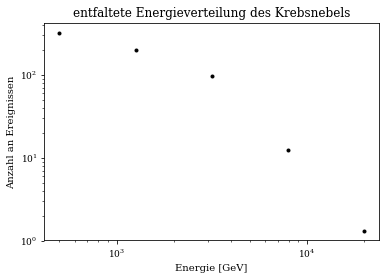

In [15]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.savefig('Entfaltung_1.pdf')
fNSVD = inv@ev

f [    0 47234 65927 20834  4470   439]
[(1, 100000), (1, 100000), (1, 100000), (1, 100000), (1, 100000), (1, 100000)]
      fun: 24.17533698046599
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.13686838e-05, -1.27897692e-05,  1.42108547e-06, -9.59232693e-06,
        1.66977543e-05,  4.34564740e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 280
      nit: 25
   status: 0
  success: True
        x: array([  8.36671839, 317.72466391, 199.2337021 ,  94.1723997 ,
        14.21024391,   1.        ])
Schätzer: [  8.36671839 317.72466391 199.2337021   94.1723997   14.21024391
   1.        ]
Kovarianzmatrix: [[ 4.04222261e+02 -3.87002693e+02  4.68779858e+01  3.26734655e+01
  -2.84756800e+00  1.03112405e-02]
 [-3.87002693e+02  9.56008977e+02 -1.75568265e+02 -7.42237507e+01
   2.36786283e+01 -6.81880071e-01]
 [ 4.68779858e+01 -1.75568265e+02  4.84899929e+02 -3.93019158e+01
  -2.30779984e+01  3.13302813e-02]
 [ 3.26734655e+01 -7.422375

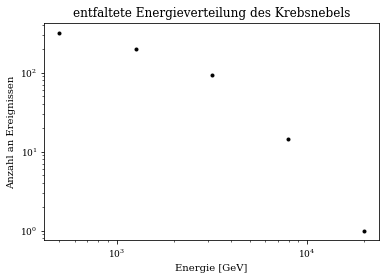

In [16]:
#negative Log-Likelihood-Entfaltung
def NegLog(f, A, b, g):
    lam = A@f + b
    return -poisson.logpmf(g, lam).sum()

f, yedges = np.histogram(gammas_sel['gamma_energy_prediction'], bins=yedge)
print('f', f)

Bounds= [(1,100000)]*len(f)
print(Bounds)

estimator = minimize(NegLog, f+100, args=(matrix, b, g), method='L-BFGS-B', bounds=Bounds)
print(estimator)
#Schätzer
fLike = estimator['x']
print('Schätzer:', fLike)

#Hessematrix aus Minimize für Fehlerrechnung auf Schätzer
Hess_Inv = estimator['hess_inv'].todense()
print('Kovarianzmatrix:',Hess_Inv)

plt.plot(yedge[:-1], fLike, 'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energie [GeV]')
plt.ylabel('Anzahl an Ereignissen')
plt.title('entfaltete Energieverteilung des Krebsnebels')
plt.savefig('Entfaltung_2.pdf')

In [17]:
#Zufallszahlen mit Multivarianten Gauss 
fLike_Var = np.random.multivariate_normal(fLike, Hess_Inv, size=10000)
fLike_Var.shape

(10000, 6)

In [18]:
def fluss(f, A, dE, t):
    return f/(A*dE*t)

t_obs = crab_runs['ontime'].sum()
t_obs

63815.89405119419

In [19]:
#Breite des Energie-bins 
Delta_E = np.diff(yedge)*10**(-3)
Delta_E

array([ 0.5       ,  0.75594322,  1.89884351,  4.76967924, 11.98089257,
       30.09464147])

In [20]:
# Detektorfläche für A_eff
A = np.pi * 27000**2 
# Bestimmung von N_sel/N_sim
hist_sel, yedges = np.histogram(gammas_sel['gamma_energy_prediction'], bins=yedge)
print(hist_sel)
hist_sim, yedges = np.histogram(gammas_corsika['total_energy'], bins=yedge)
print(hist_sim)
#Bestimmung der effektiven Fläche
A_eff = hist_sel/hist_sim * A
print('A_eff=',A_eff)

[    0 47234 65927 20834  4470   439]
[14210911  2998787   626686   130638    27226     5752]
A_eff= [0.00000000e+00 3.60733526e+07 2.40929912e+08 3.65241853e+08
 3.76011462e+08 1.74792601e+08]


[  250.           877.97160788  2205.36496908  5539.62634235
 13914.91224499 34952.67926384]


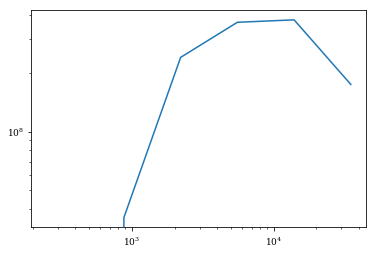

In [21]:
bincenter = (yedge[1:]+yedge[:-1])/2
plt.errorbar(bincenter, A_eff, xerr=Delta_E/2)
plt.xscale('log')
plt.yscale('log')
print(bincenter)

In [22]:
#Berechnung des Flusswertes
phi_NSVD = fNSVD[1:]/(A_eff[1:] * Delta_E[1:] * t_obs)
phi_Like = fLike[1:]/(A_eff[1:] * Delta_E[1:] * t_obs)

#Mittelwert und Standardabweichung
phi_Like_Var = fLike_Var[:,1:]/(A_eff[1:] * Delta_E[1:] * t_obs)
mean = phi_Like_Var.mean(axis=0)
std = phi_Like_Var.std(axis=0)
print('Phi_NSVD:', phi_NSVD)
print('Phi_Like:', phi_Like)
print('Mean:',mean)
print('Std:',std)

Phi_NSVD: [1.83524837e-10 6.72496491e-12 8.71636405e-13 4.33212317e-14
 3.95885293e-15]
Phi_Like: [1.82577136e-10 6.82423622e-12 8.47081248e-13 4.94290674e-14
 2.97892058e-15]
Mean: [1.82367909e-10 6.82994373e-12 8.48090994e-13 4.94189554e-14
 2.94265625e-15]
Std: [1.75809230e-11 7.44994615e-13 1.10595587e-13 1.87365361e-14
 3.01801196e-15]


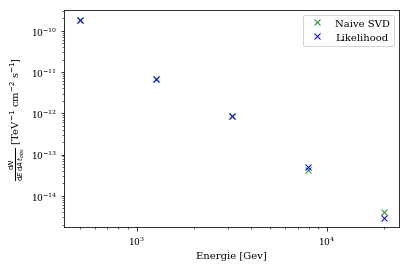

In [23]:
plt.plot(yedge[1:-1], phi_NSVD, linestyle = '', marker ='x', color = 'forestgreen', label='Naive SVD')
plt.plot(yedge[1:-1], phi_Like, linestyle = '', marker ='x', color = 'blue', label='Likelihood') 
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Energie [Gev]')
plt.ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}E \, \mathrm{d}A \, t_{obs}}$ [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.savefig('Fluss.pdf')

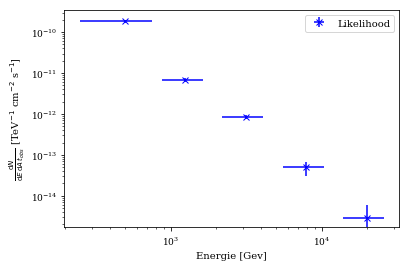

In [24]:
plt.errorbar(yedge[1:-1], mean, yerr = std, xerr=[(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge)-1)], fmt='bx', label='Likelihood')
#plt.fill_between(yedge[1:-1],mean-std,mean+std,facecolor='b',alpha=0.2, label='$1 \sigma$-Umgebung') 
#plt.fill_betweenx(mean, yedge[1:-1]-[(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge)-1)], yedge[1:-1]+[(yedge[i] - yedge[i-1])/2 for i in range(1,len(yedge)-1)],facecolor='b',alpha=0.2) 

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Energie [Gev]')
plt.ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}E \, \mathrm{d}A \, t_{obs}}$ [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.legend()
plt.savefig('Fluss_Like.pdf')

In [25]:
print([(yedge[i+1] - yedge[i]) for i in range(1,len(yedge)-1)])
print(yedge[1:-1])

[755.9432157547897, 1898.843506646175, 4769.679239904604, 11980.892565369275, 30094.641472325147]
[  500.          1255.94321575  3154.7867224   7924.46596231
 19905.35852767]
